<center>
<img src="../../img/ods_stickers.jpg">
# <center> Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 2. Визуальный анализ данных с Python
## <center>Часть 1. Обзор библиотек Seaborn, Matplotlib и Plotly


В начале как всегда настроим окружение: импортируем все необходимые библиотеки и немного настроим дефолтное отображение картинок.

In [1]:
# отключим предупреждения Anaconda
import warnings

warnings.simplefilter("ignore")

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

# увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 8, 5
import pandas as pd

После этого загрузим в `dataframe` данные, с которыми будем работать. Для примеров визуализаций я выбрала данные о продажах и оценках видео-игр с  [Kaggle Datasets](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings). Данные об оценках игр есть не для всех строк, поэтому сразу оставим только те записи, по которым есть полные данные.

In [2]:
df = pd.read_csv("../../data/video_games_sales.csv").dropna()
print(df.shape)

(6825, 16)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   object 
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(9), object(7)
memory usage: 906.4+ KB


In [4]:
df["User_Score"] = df.User_Score.astype("float64")
df["Year_of_Release"] = df.Year_of_Release.astype("int64")
df["User_Count"] = df.User_Count.astype("int64")
df["Critic_Count"] = df.Critic_Count.astype("int64")

Всего в таблице 6825 объектов и 16 признаков для них. Посмотрим на несколько первых записей c помощью метода head, чтобы убедиться, что все распарсилось правильно. Для удобства я оставила только те признаки, которые мы будем в дальнейшем использовать.

In [5]:
useful_cols = [
    "Name",
    "Platform",
    "Year_of_Release",
    "Genre",
    "Global_Sales",
    "Critic_Score",
    "Critic_Count",
    "User_Score",
    "User_Count",
    "Rating",
]
df[useful_cols].head()

,Name,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006,Sports,82.53,76.0,51,8.0,322,E
2,Mario Kart Wii,Wii,2008,Racing,35.52,82.0,73,8.3,709,E
3,Wii Sports Resort,Wii,2009,Sports,32.77,80.0,73,8.0,192,E
6,New Super Mario Bros.,DS,2006,Platform,29.80,89.0,65,8.5,431,E
7,Wii Play,Wii,2006,Misc,28.92,58.0,41,6.6,129,E


Прежде чем мы перейдем к рассмотрению методов библиотек seaborn и plotly, обсудим самый простой и зачастую удобный способ визуализировать данные из pandas dataframe — это воспользоваться функцией plot.
Для примера построим график продаж видео игр в различных странах в зависимости от года. Для начала отфильтруем только нужные нам столбцы, затем посчитаем суммарные продажи по годам и у получившегося dataframe вызовем функцию plot без параметров. 

Реализация функции plot в pandas основана на библиотеке matplotlib. 

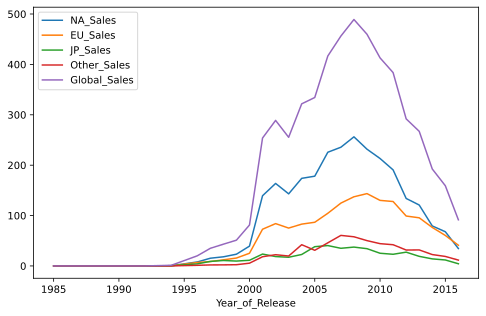

In [6]:
df[[x for x in df.columns if "Sales" in x] + ["Year_of_Release"]].groupby(
    "Year_of_Release"
).sum().plot();

C помощью параметра kind можно изменить тип графика, например, на bar chart. Matplotlib позволяет очень гибко настраивать графики. На графике можно изменить почти все, что угодно, но потребуется порыться в документации и найти нужные параметры. Например, параметра rot отвечает за угол наклона подписей к оси x.

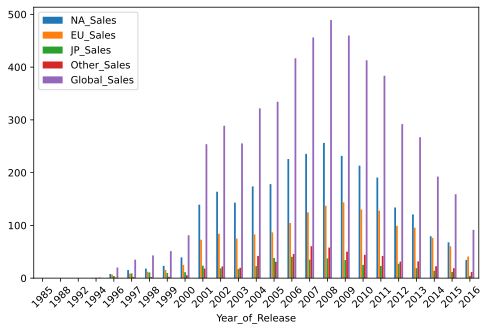

In [7]:
df[[x for x in df.columns if "Sales" in x] + ["Year_of_Release"]].groupby(
    "Year_of_Release"
).sum().plot(kind="bar", rot=45);

## Seaborn

Теперь давайте перейдем к библиотеке seaborn. Seaborn — это по сути более высокоуровневое API на базе библиотеки matplotlib. Seaborn содержит более адекватные дефолтные настройки оформления графиков. Также в библиотеке есть достаточно сложные типы визуализации, которые в matplotlib потребовали бы большого количество кода.

Познакомимся с первым таким "сложным" типом графиков pair plot (scatter plot matrix). Эта визуализация поможет нам посмотреть на одной картинке, как связаны между собой различные признаки. 

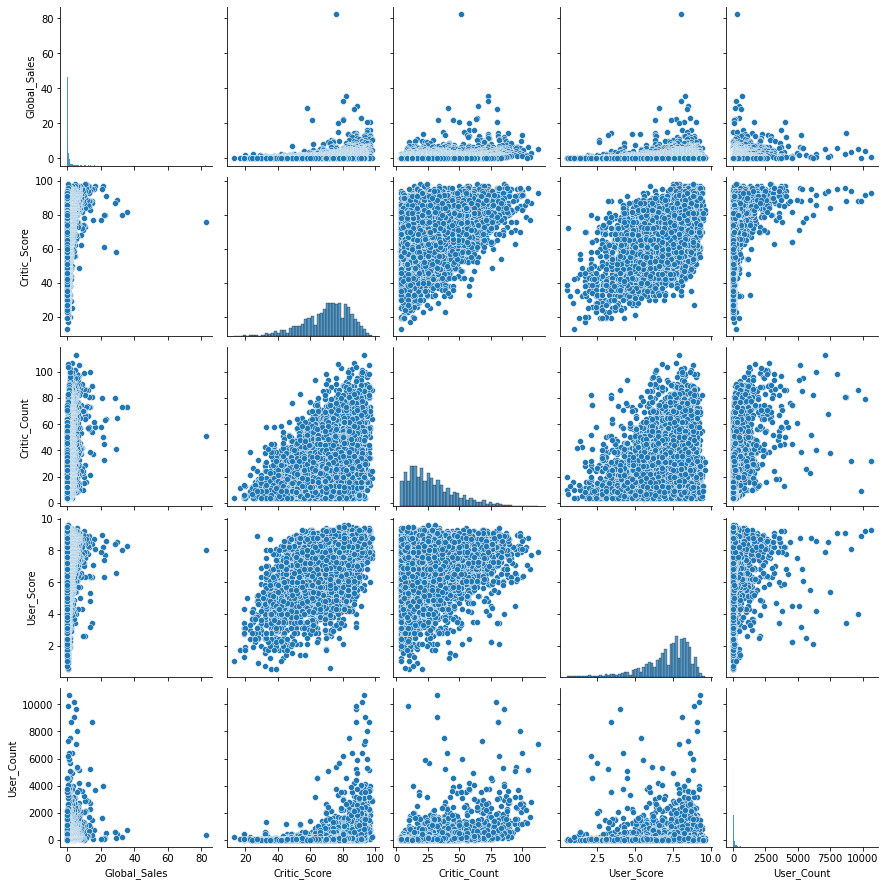

In [12]:
# c svg pairplot браузер начинает тормозить
%config InlineBackend.figure_format = 'png'
sns.pairplot(
    df[["Global_Sales", "Critic_Score", "Critic_Count", "User_Score", "User_Count"]]
);

Также с помощью `seaborn` можно построить распределение, для примера посмотрим на распределение оценок критиков `Critic_Score`. Для этого построим __`distplot`__. По default'у на графике отображается гистограмма и [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

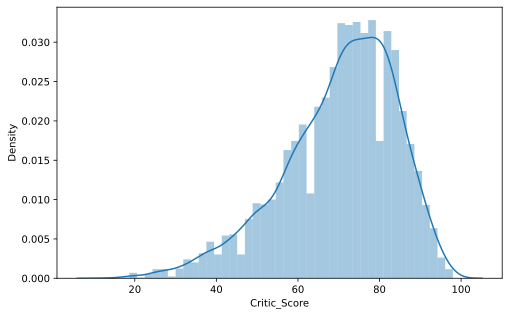

In [13]:
%config InlineBackend.figure_format = 'svg'
sns.distplot(df.Critic_Score);

Для того чтобы подробнее посмотреть на взаимосвязь двух численных признаков, есть еще и __`joint_plot`__ – это гибрид `scatter plot` и `histogram` (отображаются также гистограммы распределений признаков). Посмотрим на то, как связаны между собой оценка критиков `Critic_Score` и оценка пользователя `User_Score`.

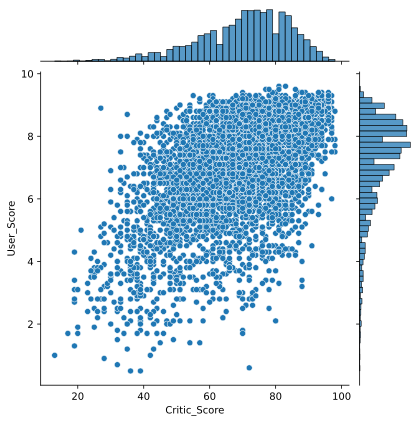

In [11]:
sns.jointplot(x="Critic_Score", y="User_Score", data=df, kind="scatter");

Еще один полезный тип графиков – это __`box plot`__. Давайте сравним пользовательские оценки игр для топ-5 крупнейших игровых платформ.

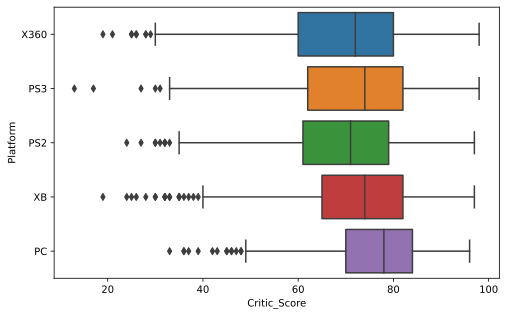

In [14]:
top_platforms = (
    df.Platform.value_counts().sort_values(ascending=False).head(5).index.values
)
sns.boxplot(
    y="Platform", x="Critic_Score", data=df[df.Platform.isin(top_platforms)], orient="h"
);

Думаю, стоит обсудить немного подробнее, как же понимать `box plot`. `Box plot` состоит из коробки (поэтому он и называется `box plot`), усиков и точек. Коробка показывает интерквантильный размах распределения, то есть соответственно 25% (`Q1`) и 75% (`Q3`) процентили. Черта внутри коробки обозначает медиану распределения. 
С коробкой разобрались, перейдем к усам. Усы отображают весь разброс точек кроме выбросов, то есть минимальные и максимальные значения, которые попадают в промежуток `(Q1 - 1.5*IQR, Q3 + 1.5*IQR)`, где `IQR = Q3 - Q1` - интерквантильный размах. Точками на графике обозначаются выбросы (`outliers`) - те значения, которые не вписываются в промежуток значений, заданный усами графика.


И еще один тип графиков (последний из тех, которые мы рассмотрим в этой статье) - это __`heat map`__. `Heat map` позволяет посмотреть на распределение какого-то численного признака по двум категориальным. Визуализируем суммарные продажи игр по жанрам и игровым платформам.

In [15]:
platform_genre_sales = (
    df.pivot_table(
        index="Platform", columns="Genre", values="Global_Sales", aggfunc=sum
    )
    .fillna(0)
    .applymap(float)
)

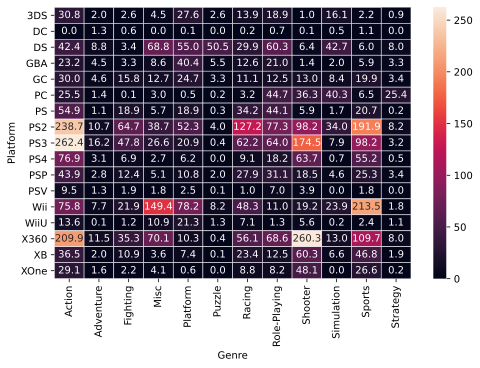

In [16]:
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=0.5);

## Plotly

Мы рассмотрели визуализации на базе библиотеки `matplotlib`. Однако, это не единственная опция для построения графиков на языке `python`. Познакомимся также с библиотекой __`plotly`__. `Plotly` - это open-source библиотека, которая позволяет строить интерактивные графики в jupyter.notebook'e без необходимости зарываться в javascript код. 

Прелесть интерактивных графиков заключается в том, что можно посмотреть точное численное значение при наведении мыши, скрыть неинтересные ряды в визуализации, приблизить определенный участок графика и т.д.

Перед началом работы импортируем все необходимые модули и инициализируем `plotly` с помощью команды `init_notebook_mode`.

In [17]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)

Для начала построим __`line plot`__ с динамикой числа вышедших игр и их продаж по годам. 

In [19]:
years_df = (
    df.groupby("Year_of_Release")[["Global_Sales"]]
    .sum()
    .join(df.groupby("Year_of_Release")[["Name"]].count())
)
years_df.columns = ["Global_Sales", "Number_of_Games"]

В `plotly` строится визуализация объекта `Figure`, который состоит из данных (массив линий, которые в библиотеке называются `traces`) и оформления/стиля, за который отвечает объект `layout`. В простых случаях можно вызывать функцию `iplot` и просто от массива `traces`.

In [20]:
trace0 = go.Scatter(x=years_df.index, y=years_df.Global_Sales, name="Global Sales")

trace1 = go.Scatter(
    x=years_df.index, y=years_df.Number_of_Games, name="Number of games released"
)

data = [trace0, trace1]
layout = {"title": "Statistics of video games"}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

Также можно сразу сохранить график в виде html-файла.

In [21]:
plotly.offline.plot(fig, filename="years_stats.html", show_link=False);

Посмотрим также на рыночную долю игровых платформ, расчитанную по количеству выпущенных игр и по суммарной выручке. Для этого построим __`bar chart`__.

In [22]:
platforms_df = (
    df.groupby("Platform")[["Global_Sales"]]
    .sum()
    .join(df.groupby("Platform")[["Name"]].count())
)
platforms_df.columns = ["Global_Sales", "Number_of_Games"]
platforms_df.sort_values("Global_Sales", ascending=False, inplace=True)

In [23]:
trace0 = go.Bar(x=platforms_df.index, y=platforms_df.Global_Sales, name="Global Sales")

trace1 = go.Bar(
    x=platforms_df.index,
    y=platforms_df.Number_of_Games,
    name="Number of games released",
)

data = [trace0, trace1]
layout = {"title": "Share of platforms"}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

В `plotly` можно построить и __`box plot`__. Рассмотрим различия оценок критиков в зависимости от жанра игры.

In [24]:
data = []

for genre in df.Genre.unique():
    data.append(go.Box(y=df[df.Genre == genre].Critic_Score, name=genre))
iplot(data, show_link=False)